# Implementing Particle Swarm Optimization For Mock Assessment Solution

In [4]:
# Installing the necessary requirements
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install networkx

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import networkx as nx
from networkx.classes import neighbors

In [2]:
colnames = ['Node', 'Position1', 'Position2']
position_data = pd.read_csv('sub_data_file.csv', header=None, names=colnames, index_col=['Node']) # Reading and assigning the nodes as index, to remove redundancy
# Adding the last two base stations to the dataset just incase it's not present in the csv.
position_data.loc[151] = [5000, -5000]
position_data.loc[152] = [-5000, 5000]
position_data.head()

,Position1,Position2
Node,,
1,4873.6,4886.7
2,-3295.7,-4330.5
3,-2407.1,4397.4
4,-1027.0,-4828.9
5,-4260.1,1838.4


## Plotting The points

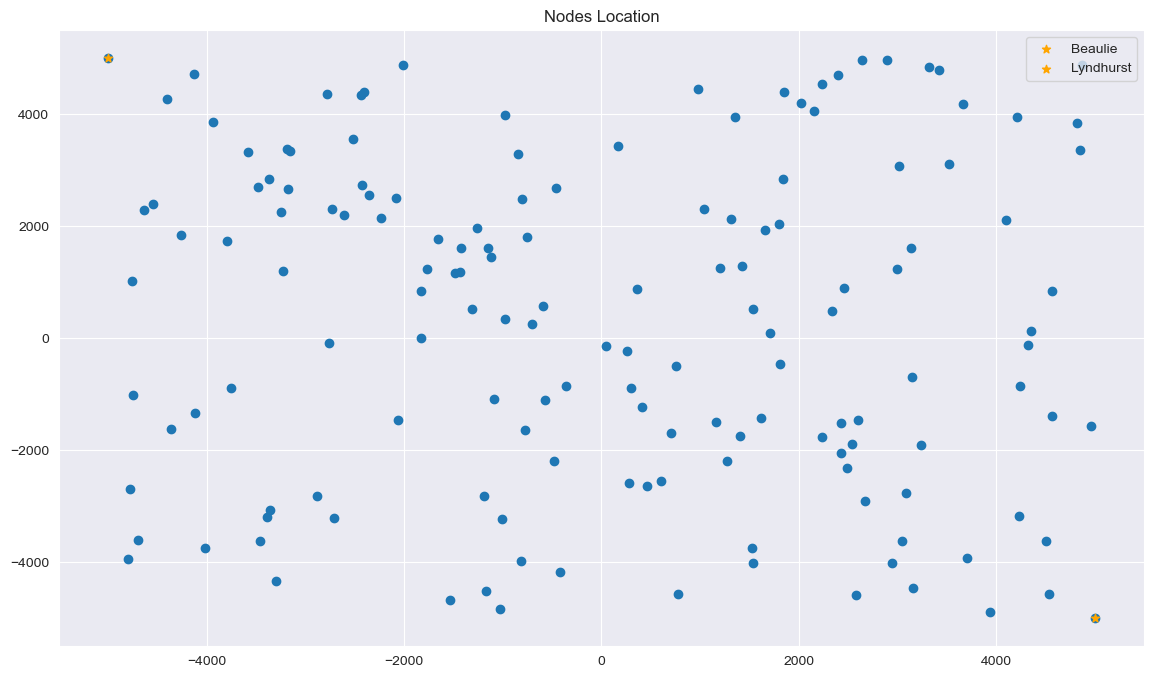

In [34]:
coordinate_x = position_data['Position1']
coordinate_y = position_data['Position2']

# Input Beaulieu and Lyndhurst coordinates
beaulie_coordinate = (5000, -5000)
lyndhurst_coordinate = (-5000, 5000)

plt.figure(figsize = (14, 8))
plt.title('Nodes Location')
plt.scatter(coordinate_x, coordinate_y)
plt.scatter(beaulie_coordinate[0], beaulie_coordinate[1], label='Beaulie', color='orange', marker='*')
plt.scatter(lyndhurst_coordinate[0], lyndhurst_coordinate[1], label='Lyndhurst', color='orange', marker='*')
plt.legend(loc='upper right')
plt.show()

> We are Going to create a function to get the particle to reach a destination vertex either 151, or 152.

In [35]:
def calculate_distance(x1, x2, y1, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
distances = [] # List for appending in dataframe
for i in range(len(position_data)):
    for j in range(i + 1, len(position_data)):
        id1 = position_data.index[i]
        id2 = position_data.index[j]
        x1, y1 = position_data.iloc[i]['Position1'], position_data.iloc[i]['Position2']
        x2, y2 = position_data.iloc[j]['Position1'], position_data.iloc[j]['Position2']
        distance = calculate_distance(x1, x2, y1, y2)
        distances.append({"point1": id1, "point2": id2, "distance": distance})

distance_df = pd.DataFrame(distances)
print(f'There are total of {len(distance_df)} points.')
distance_df.loc[(distance_df['point1'] == 1)& (distance_df['point2'] == 141)]

There are total of 11476 points.


,point1,point2,distance
139,1,141,7623.831483


In [36]:
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, float('inf')]
labels = [7,5,4,3,2,1,0]
distance_df['transmission'] = pd.cut(distance_df['distance'], bins=bins, labels=labels, right=False)
distance_df.drop(distance_df.index[distance_df['transmission'] == 0], inplace=True)
distance_df.head()

,point1,point2,distance,transmission
6,1,8,1034.795366,4
18,1,20,1552.523752,3
38,1,40,2232.795239,2
40,1,42,2475.977770,2
53,1,55,2932.511040,1


In [37]:
# Adding the graph data type for simplicity.
G = nx.Graph()
for _, row in distance_df.iterrows():
    G.add_edge(row['point1'], row['point2'], weight=row['transmission'])


In [38]:
print(f"Graph edges with weights: {list(G.edges(data=True))}")

Graph edges with weights: [(1.0, 8.0, {'weight': 4.0}), (1.0, 20.0, {'weight': 3.0}), (1.0, 40.0, {'weight': 2.0}), (1.0, 42.0, {'weight': 2.0}), (1.0, 55.0, {'weight': 1.0}), (1.0, 76.0, {'weight': 4.0}), (1.0, 86.0, {'weight': 1.0}), (1.0, 93.0, {'weight': 3.0}), (1.0, 94.0, {'weight': 2.0}), (1.0, 100.0, {'weight': 4.0}), (1.0, 114.0, {'weight': 4.0}), (1.0, 127.0, {'weight': 1.0}), (1.0, 133.0, {'weight': 1.0}), (1.0, 146.0, {'weight': 3.0}), (1.0, 150.0, {'weight': 1.0}), (8.0, 20.0, {'weight': 3.0}), (8.0, 40.0, {'weight': 2.0}), (8.0, 42.0, {'weight': 1.0}), (8.0, 55.0, {'weight': 1.0}), (8.0, 76.0, {'weight': 5.0}), (8.0, 86.0, {'weight': 1.0}), (8.0, 93.0, {'weight': 2.0}), (8.0, 94.0, {'weight': 4.0}), (8.0, 100.0, {'weight': 4.0}), (8.0, 114.0, {'weight': 3.0}), (8.0, 127.0, {'weight': 1.0}), (8.0, 133.0, {'weight': 3.0}), (8.0, 136.0, {'weight': 1.0}), (8.0, 146.0, {'weight': 7.0}), (8.0, 150.0, {'weight': 3.0}), (20.0, 6.0, {'weight': 2.0}), (20.0, 17.0, {'weight': 3.0}), 

> Some important functions to check path validity

In [41]:
# Function to check valid paths
# Should remove the ones with zero weights just to make sure the path is valid at all points.
# Don't think we will be using this function anymore because have already removed all zeros transmissions
def is_valid_path(path, graph):
    for i in range(len(path) - 1):
        if not graph.has_edge(path[i], path[i + 1]):
            return False
    return True

In [42]:
G[1][8].get('weight', float('inf'))

4.0

In [43]:
import random
NUM_PARTICLES=1
def initialize_population_from_df(start_node, distance_df, max_length=6):
    """
    Generate population using valid connections from distance_df.
    """
    population = []
    retries = 0
    valid_edges = list(zip(distance_df['point1'], distance_df['point2']))
    graph = nx.Graph(valid_edges)  # Create a graph from the valid connections

    while len(population) < NUM_PARTICLES and retries < 10000:
        retries += 1
        path = [start_node]
        current_node = start_node

        # Randomly select nodes to form a path
        for _ in range(random.randint(1, max_length - 2)):  # Middle part length
            neighbors = list(graph.neighbors(current_node))
            if not neighbors:
                break  # No valid neighbors, stop path construction
            next_node = random.choice(neighbors)
            if next_node not in path:  # Avoid cycles
                path.append(next_node)
                current_node = next_node

        # Append valid end node
        end_node = random.choice([151, 152])
        if graph.has_edge(current_node, end_node):
            path.append(end_node)
            population.append(path)
            retries = 0  # Reset retries on success

    # Fallback: Print warning if retries exceeded
    if len(population) < NUM_PARTICLES:
        print(f"Warning: Could only generate {len(population)} valid paths after 100 retries.")
    return population
population = initialize_population_from_df(1, distance_df, max_length=20)
print(population[0])
print(len(population))

[1, 8, 86, 127, 100, 59, 6, 101, 130, 122, 46, 131, 61, 151]
1


In [92]:
def initialize_population(start_node,graph,valid_end_nodes=[151,152], max_length=50):
    """
    This function initializes population in a rule of getting valid paths from
    valid end nodes. We didn't use max length so particles can take any length they want
    and keep on updating their path.
    :param start_node: node to start from example 2, 1, any
    :param graph: the graph object defined in the previous step (graph = nx.Graph(valid_edges))
    :param valid_end_nodes: these are nodes to end the path at. For assignment, it's 151 and 152.
    :param max_length: the maximum length of the path, we didn't use this parameter.'
    :return:
    """
    current_node = start_node # The starting point of our function.
    elems = [current_node] # This list holds the elements of the population
    # Basically here we loop until the last elem has valid end nodes. The neighbor are from the
    # graph. break condition included incase we don't find neighbors.
    while elems[-1] not in valid_end_nodes:
        neighbors = [neighbor for neighbor in graph.neighbors(current_node) if neighbor not in elems]
        if not neighbors:
            break
        next_node = random.choice(neighbors)
        elems.append(next_node)
        current_node = next_node
    return elems

In [93]:
populations = [initialize_population(1,G,valid_end_nodes=[151,152]) for _ in range(20)]

In [94]:
initialize_population(1, G)

[1, 146.0, 40.0, 6.0, 148.0, 115.0, 19.0, 112.0, 14.0, 53.0, 57.0, 151.0]

In [95]:
def initialize_velocities(population, graph):
    """
    This  function initializes velocities for each particle in the population.
    In our case we have introduced our own research (We don't know if it exists) into the velocities. But the velocity is (direction to go , some weight and the place to update and start search from).
    :param population: population object defined in the previous step (population = [initialize_population(1,G,valid_end_nodes=[151,152]) for _ in range(20)])
    :param graph: graph object defined in the previous step (graph = nx.Graph(valid_edges))
    :return: (direction, weight_criteria, update_index)
    """
    velocities = []
    for individual in population:
       direction = individual[-1]
       weights = [
            graph[individual[i]][individual[i + 1]].get('weight', float('inf'))
            for i in range(len(individual) - 1)
        ]
       average_weight = np.mean(weights) if weights else float('inf')
       update_index = random.randint(1, len(individual) - 1)
       velocity = (direction, average_weight, update_index)
       velocities.append(velocity)
    return velocities

In [96]:
velocities = initialize_velocities(populations, G)
print(populations[0])
print(velocities[0])

[1, 76.0, 146.0, 134.0, 115.0, 139.0, 66.0, 62.0, 90.0, 73.0, 14.0, 78.0, 116.0, 84.0, 120.0, 118.0, 97.0, 145.0, 124.0, 41.0, 72.0, 105.0, 67.0, 13.0, 132.0, 48.0, 11.0, 147.0, 109.0, 18.0, 83.0, 32.0, 141.0, 5.0, 121.0, 56.0, 102.0, 30.0, 130.0, 108.0, 122.0, 104.0, 39.0, 107.0, 148.0, 46.0, 43.0, 140.0, 58.0, 87.0, 133.0, 20.0, 100.0, 21.0, 94.0, 52.0, 136.0, 36.0, 92.0, 64.0, 91.0, 65.0, 24.0, 26.0, 89.0, 22.0, 106.0, 79.0, 10.0, 95.0, 129.0, 138.0, 131.0, 45.0, 143.0, 112.0, 35.0, 59.0, 135.0, 19.0, 27.0, 81.0, 85.0, 37.0, 49.0, 103.0, 28.0, 61.0, 77.0, 15.0, 53.0, 57.0, 151.0]
(151.0, 2.5652173913043477, 54)


In [186]:
def update_velocity(position, velocity, global_best_position, personal_best_position,
                    personal_best_fitness, global_best_fitness, current_fitness,
                    inertia=0.7, c1=1.5, c2=1.5):
    """
    Update the velocity of the particle in PSO, considering the influence of global and personal bests.

    Parameters:
        position (list): Current path of the particle.
        velocity (tuple): (direction, weight_criteria, update_index).
        global_best_position (list): Global best path across all particles.
        personal_best_position (list): This particle's personal best path.
        Returns:
        tuple: New velocity (direction, weight_criteria, update_index).
    """
    # Unpack the velocity tuple
    direction, weight_criteria, update_index = velocity

    # Initialize momentum with inertia
    momentum = inertia * weight_criteria

    # Identify the common update direction
    if personal_best_fitness < current_fitness:  # Move towards personal best
        # Cognitive influence: Focus on personal best improvement
        start_index = max(0, len(personal_best_position) - update_index)
        cognitive_difference = [
            personal_best_position[i] - position[min(i, len(position) - 1)]
            for i in range(start_index, len(personal_best_position))
            if i < len(position)
        ]
        cognitive_influence = c1 * np.random.random() * np.mean(cognitive_difference) if cognitive_difference else 0.0
    else:
        cognitive_influence = 0.0

    # Global influence: Incorporate random exploration around the global best position
    if np.random.random() < 0.5:
        random_index = np.random.randint(0, len(global_best_position))
        if random_index < len(position):  # Avoid indexing error
            social_difference = global_best_position[random_index] - position[random_index]
            social_influence = c2 * np.random.random() * social_difference
        else:
            social_influence = 0.0
    else:
        social_influence = 0.0

    # Compute the new weight (influence of all components)
    new_weight_criteria = momentum + cognitive_influence + social_influence

    # Direction alternates between personal and global best
    if cognitive_influence > social_influence:  # Focus on personal best
        direction = personal_best_position[-1] if personal_best_position else position[-1]
        new_update_index = np.random.randint(max(1, len(personal_best_position) - update_index),
                                             len(personal_best_position))
    else:  # Focus on global best
        direction = global_best_position[-1] if global_best_position else position[-1]
        new_update_index = np.random.randint(1, len(global_best_position))

    return direction, new_weight_criteria, new_update_index


In [187]:
def update_position(position, velocity, graph):
    """
    Updates the position based on velocity and graph structure.
    Important thing here is neighbors. How to choose the direction.
    As a bad choice can lead to very long paths and poor performance.
    Also, we multiplied weight criteria by 0.9 / any scaler to get it to choose better number (to reduce search of weight criteria by small number.)
    This should be updated in the future.

    Parameters:
        position (list): Current position (path) of the particle.
        velocity (tuple): (direction, min_weight, update_index).
        graph (networkx.Graph): The graph with weighted edges.

    Returns:
        list: Updated position (path).
    """
    direction, min_weight, update_index = velocity
    start_node = position[:update_index]  # Partial path up to the update index
    current_node = start_node[-1]
    elems = start_node.copy()

    while elems[-1] != direction:  # Stop when reaching the desired direction
        neighbors = [neighbor for neighbor in graph.neighbors(current_node) if neighbor not in elems]

        # Prefer neighbors leading toward the target direction
        if direction in neighbors:
            elems.append(direction)
            return elems

        if not neighbors:
            # If no neighbors, return the initial position
            return position

        # Choose neighbors with valid weights
        weighted_neighbors = [
            (neighbor, graph[current_node][neighbor].get('weight', float('inf'))) for neighbor in neighbors
        ]
        valid_neighbors = [neighbor for neighbor, weight in weighted_neighbors if weight >= min_weight]

        if not valid_neighbors:
            # If no valid neighbors, reduce weight criteria slightly to explore
            min_weight *= 0.9
            valid_neighbors = [neighbor for neighbor, weight in weighted_neighbors if weight >= min_weight]

            if not valid_neighbors:
                return position  # Return to initial position if no valid moves

        # Choose a random valid neighbor
        next_node = random.choice(valid_neighbors)
        elems.append(next_node)
        current_node = next_node

    return elems

In [188]:
# Just checking random path generated to see if everything works fine.
update_position([1, 86.0, 150.0, 17.0, 21.0, 59.0, 10.0, 98.0, 64.0, 112.0, 27.0, 137.0, 128.0, 88.0, 4.0, 105.0, 129.0, 116.0, 115.0, 95.0, 26.0, 125.0, 111.0, 104.0, 142.0, 63.0, 60.0, 152.0], (152.0, 3.037037037037037, 13), G)

[1,
 86.0,
 150.0,
 17.0,
 21.0,
 59.0,
 10.0,
 98.0,
 64.0,
 112.0,
 27.0,
 137.0,
 128.0,
 38.0,
 4.0,
 88.0,
 67.0,
 12.0,
 143.0,
 58.0,
 139.0,
 95.0,
 89.0,
 91.0,
 16.0,
 107.0,
 113.0,
 34.0,
 102.0,
 141.0,
 119.0,
 22.0,
 80.0,
 33.0,
 69.0,
 152.0]

## We have come up with this fitness function where we can minimize the cost function of transmission rate and latency to obtain optimal particles.

\begin{align*}
\text{Fitness Function:} \quad
F(\text{path}) &= w_{\text{latency}} \cdot \text{norm\latency} - w{\text{rate}} \cdot \text{norm\_rate} \\
\text{where:} \\
\text{norm\_latency} &= \frac{\text{total\_latency}}{30 \cdot (|V| - 1)} \\
\text{total\_latency} &= 30 \cdot (|\text{path}| - 1) \\
\text{norm\_rate} &= \frac{\text{min\_transmission\_rate}}{\max \left( \{ \text{weight}(u,v) \mid (u,v) \in E \} \right)}
\end{align*}

In [189]:
def fitness_function(path, graph, w_latency=1.0, w_rate=1.0):
    """
    Fitness function that balances latency minimization and rate maximization.

    Parameters:
        path (list): The particle's current path (sequence of nodes).
        graph (networkx.Graph): The graph structure with weighted edges.
        w_latency (float): Weight for latency minimization.
        w_rate (float): Weight for rate maximization.

    Returns:
        float: Fitness of the path (lower is better).
    """
    # Calculate total latency
    total_latency = 30 * (len(path) - 1)  # Fixed latency cost per hop.

    # Find the bottleneck (minimum transmission rate)
    min_transmission_rate = float("inf")  # Start with infinity for the rate.
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        if graph.has_edge(u, v):
            edge_data = graph[u][v]
            min_transmission_rate = min(min_transmission_rate, edge_data["weight"])
        else:
            return float("inf")  # Invalid paths with missing edges have infinite cost.

    # Normalize metrics to range [0, 1]
    norm_latency = total_latency / (30 * (len(graph.nodes()) - 1))  # Normalized latency
    norm_rate = min_transmission_rate / max(
        [data["weight"] for _, _, data in graph.edges(data=True)])  # Normalized rate

    # Fitness combines latency (minimization) and rate (maximization)
    # Note: Subtract norm_rate to maximize rate (rate is good when it's higher)
    return w_latency * norm_latency - w_rate * norm_rate


In [190]:
fitness_function(populations[0], G)

0.4664143803216651

In [191]:
fitnesses = [fitness_function(path, G) for path in populations]

In [192]:
min(fitnesses), max(fitnesses)

(0.022705771050141932, 0.804162724692526)

In [251]:
NUM_PARTICLES = 100

def pso(graph, start_node, df, max_length=20, iterations=10):
    """
    PSO implementation for pathfinding in a graph using valid paths.
    """
    # Step 1: Initialize Population
    population = [initialize_population(start_node, graph=graph, valid_end_nodes=[151, 152]) for _ in range(NUM_PARTICLES)]
    velocities = initialize_velocities(population, graph=graph)
    #print(f'Initial Population: {population}')

    # Calculate Initial Fitness
    fitnesses = [fitness_function(path, graph) for path in population]
    personal_best_positions = population.copy()
    personal_best_fitnesses = fitnesses.copy()

    # Identify Initial Global Best
    global_best_index = np.argmin(personal_best_fitnesses)
    global_best_position = personal_best_positions[global_best_index]
    global_best_fitness = personal_best_fitnesses[global_best_index]

    final_global_best_fitnesses = []

    # Step 2: Main PSO Loop
    for iteration in range(iterations):
        for i in range(NUM_PARTICLES):
            current_fitness = fitness_function(population[i], graph)
            # Update velocity
            velocities[i] = update_velocity(
                position=population[i],
                velocity=velocities[i],
                global_best_position=global_best_position,
                global_best_fitness=global_best_fitness,
                personal_best_position=personal_best_positions[i],
                personal_best_fitness=personal_best_fitnesses[i],
                current_fitness=current_fitness,
            )

            # Update position based on new velocity
            new_position = update_position(population[i], velocities[i], graph)
            # if population[i] == new_position:
            #     print(f'Particle {i} did not move. Skipping iteration.')
            # else:
            #     print(f'Particle {i} moved to {new_position}')

            # Evaluate fitness of the new position
            new_fitness = fitness_function(new_position, graph)

            # Update personal best if the new fitness is better
            if new_fitness < personal_best_fitnesses[i]:
                personal_best_fitnesses[i] = new_fitness
                personal_best_positions[i] = new_position
                if new_fitness < global_best_fitness:
                    global_best_fitness = new_fitness
                    global_best_position = new_position
                population[i] = new_position
                # print(f'Particle {i} updated personal best to {new_position} with fitness {new_fitness}')
            else:
                population[i] = population[i]


        # Log progress every 10 iterations
        if iteration % 10 == 0 or iteration == iterations - 1:
            print(f"Iteration {iteration}: Global Best Fitness = {global_best_fitness}")
            print(f"Global Best Position: {global_best_position}")

        final_global_best_fitnesses.append(global_best_fitness)

    # Step 3: Output Final Solution
    print(f'Final Population: {population}')
    print("\nFinal Results:")
    print(f"Best Path Found: {global_best_position}")
    print(f"Best Fitness: {global_best_fitness}")
    return population, global_best_fitness

In [252]:
final_population, final_best_fitness = pso(graph=G,start_node=2, df=distance_df, max_length=20, iterations=200)

Iteration 0: Global Best Fitness = -0.3093661305581835
Global Best Position: [2, 147.0, 48.0, 75.0, 149.0, 132.0, 109.0, 31.0, 83.0, 47.0, 67.0, 12.0, 25.0, 7.0, 29.0, 39.0, 144.0, 44.0, 152.0]
Iteration 10: Global Best Fitness = -0.3093661305581835
Global Best Position: [2, 147.0, 48.0, 75.0, 149.0, 132.0, 109.0, 31.0, 83.0, 47.0, 67.0, 12.0, 25.0, 7.0, 29.0, 39.0, 144.0, 44.0, 152.0]
Iteration 20: Global Best Fitness = -0.3093661305581835
Global Best Position: [2, 147.0, 48.0, 75.0, 149.0, 132.0, 109.0, 31.0, 83.0, 47.0, 67.0, 12.0, 25.0, 7.0, 29.0, 39.0, 144.0, 44.0, 152.0]
Iteration 30: Global Best Fitness = -0.3093661305581835
Global Best Position: [2, 147.0, 48.0, 75.0, 149.0, 132.0, 109.0, 31.0, 83.0, 47.0, 67.0, 12.0, 25.0, 7.0, 29.0, 39.0, 144.0, 44.0, 152.0]
Iteration 40: Global Best Fitness = -0.3093661305581835
Global Best Position: [2, 147.0, 48.0, 75.0, 149.0, 132.0, 109.0, 31.0, 83.0, 47.0, 67.0, 12.0, 25.0, 7.0, 29.0, 39.0, 144.0, 44.0, 152.0]
Iteration 50: Global Best 

In [253]:
def rate_latency(final_population):
    """
    Calculate the latency and minimum weight transmission rate for each path in the population.

    Parameters:
        final_population (list of lists): The population of paths, where each path is a list of nodes.

    Returns:
        list of tuples: A list where each tuple contains (transmission rate, latency) for a path.
    """
    results = []  # Store (transmission_rate, latency) for each path

    for path in final_population:
        weights = []  # Store edge weights for this specific path

        # Calculate weights for the edges in the path
        for current_node, next_node in zip(path[:-1], path[1:]):
            # Get the weight of the edge or assign 'inf' if it doesn't exist
            weight = G[current_node][next_node].get('weight', float('inf'))
            weights.append(weight)

        # Calculate the minimum weight (transmission rate) and latency for the path
        transmission_rate = min(weights)
        latency = 30 * (len(path) - 1)

        # Add the results as a tuple to the list
        results.append((transmission_rate, latency))

    return results


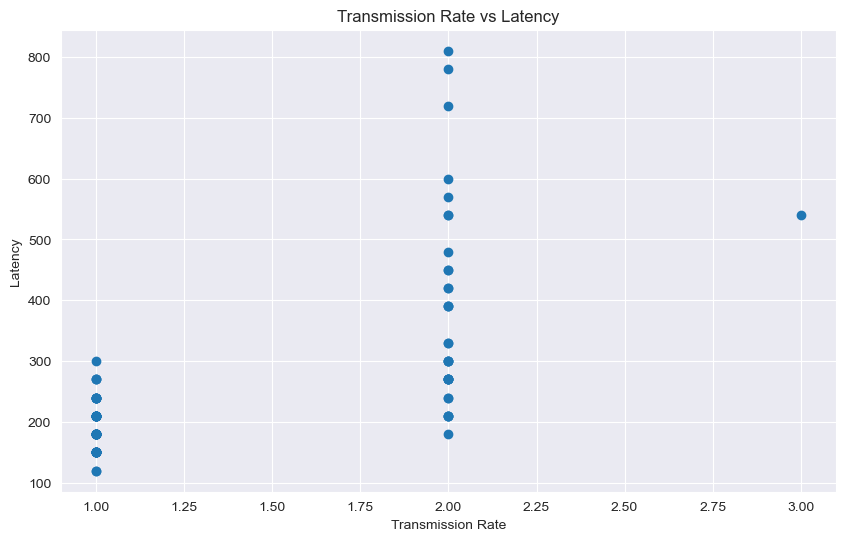

In [254]:
results = rate_latency(final_population)
transmission_rate = [rate for rate, latency in results]
latencies = [latency for rate, latency in results]
plt.figure(figsize=(10, 6))
plt.scatter(transmission_rate, latencies,)
plt.xlabel("Transmission Rate")
plt.ylabel("Latency")
plt.title("Transmission Rate vs Latency")
plt.show()

> For Us we are going to use the one with high transmission rate and low latency.
and for that reason that's the best path.

In [255]:
# Sorting the results and get the final best path.
sorted_results = sorted(zip(final_population, results), key=lambda x: (-x[1][0], x[1][1]))
best_path, (best_transmission_rate, best_latency) = sorted_results[0]
print(f"Final Best Path: {best_path} with Transmission Rate = {best_transmission_rate} and Latency = {best_latency}")

Final Best Path: [2, 147.0, 48.0, 75.0, 149.0, 132.0, 109.0, 31.0, 83.0, 47.0, 67.0, 12.0, 25.0, 7.0, 29.0, 39.0, 144.0, 44.0, 152.0] with Transmission Rate = 3.0 and Latency = 540


In [256]:
"""
TODO:
1. Finish Pareto front function.
2. Calculate the rate and latency of each path.
3. Find the Pareto-optimal solutions.
4. Print the results.
"""
def find_pareto_optimal_paths(final_population, results):
    """
    Identify Pareto-optimal paths based on transmission rate and latency.

    Parameters:
        final_population (list of lists): The population of paths, where each path is a list of nodes.
        results (list of tuples): Each tuple contains (transmission_rate, latency) for a path.

    Returns:
        list of tuples: Pareto-optimal paths and their metrics [(path, (transmission_rate, latency)), ...].
    """
    pareto_paths = []  # Store Pareto-optimal paths

    for i, (path, (transmission_rate, latency)) in enumerate(zip(final_population, results)):
        # Check if the current path is dominated by any other path
        is_dominated = False
        for j, (other_path, (other_transmission_rate, other_latency)) in enumerate(zip(final_population, results)):
            if (other_transmission_rate > transmission_rate and other_latency <= latency) or \
                    (other_transmission_rate >= transmission_rate and other_latency < latency):
                is_dominated = True
                break

        # If the path is not dominated, add it to Pareto-optimal list
        if not is_dominated:
            pareto_paths.append((path, (transmission_rate, latency)))

    return pareto_paths


# Call the rate_latency function to calculate metrics for each path
rate_latency_results = rate_latency(final_population)

# Find Pareto-optimal paths
pareto_optimal_paths = find_pareto_optimal_paths(final_population, rate_latency_results)

# Print Pareto-optimal paths
print("Pareto-optimal Paths:")
for path, (transmission_rate, latency) in pareto_optimal_paths:
    print(f"Path: {path}, Transmission Rate: {transmission_rate}, Latency: {latency}")



Pareto-optimal Paths:
Path: [2, 147.0, 48.0, 75.0, 149.0, 132.0, 109.0, 31.0, 83.0, 47.0, 67.0, 12.0, 25.0, 7.0, 29.0, 39.0, 144.0, 44.0, 152.0], Transmission Rate: 3.0, Latency: 540
Path: [2, 83.0, 32.0, 126.0, 152.0], Transmission Rate: 1.0, Latency: 120
Path: [2, 47.0, 121.0, 56.0, 152.0], Transmission Rate: 1.0, Latency: 120
Path: [2, 13.0, 83.0, 121.0, 39.0, 125.0, 152.0], Transmission Rate: 2.0, Latency: 180


In [257]:
#12 -> 143 -> 25 -> 46 -> 19 -> 116 -> 124 -> 112 -> 28 -> 61 -> 145 -> 15 -> 53 -> 57 -> 151, Maximum Transmission Rate: 151, Latency: 420 ms
fitness_function(best_path, G)

-0.3093661305581835

In [275]:
from matplotlib.cm import get_cmap

def plot_points(df, pareto_optimal_paths):
    """
    We are plotting the pareto-optimal paths and for the particular point.
    """
    coordinate_x = df['Position1']
    coordinate_y = df['Position2']

    plt.figure(figsize=(12, 8))
    plt.title('Nodes and Pareto-Optimal Paths')
    plt.scatter(coordinate_x, coordinate_y, color='black', label='Nodes', zorder=3)
    colors = plt.cm.get_cmap('tab10', len(pareto_optimal_paths))

    # Plot each Pareto-optimal path with a unique color
    for idx, (path, _) in enumerate(pareto_optimal_paths):
        path_coords = [tuple(df.loc[i, ['Position1', 'Position2']].tolist()) for i in path]
        for j in range(len(path_coords) - 1):
            plt.plot(
                [path_coords[j][0], path_coords[j + 1][0]],
                [path_coords[j][1], path_coords[j + 1][1]],
                color=colors(idx),
                linewidth=2,
                zorder=2
            )
        plt.plot([], [], color=colors(idx), label=f'Path {idx + 1}', zorder=1)

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend(loc='upper right')
    plt.show()

/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_1607/2553887791.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(pareto_optimal_paths))


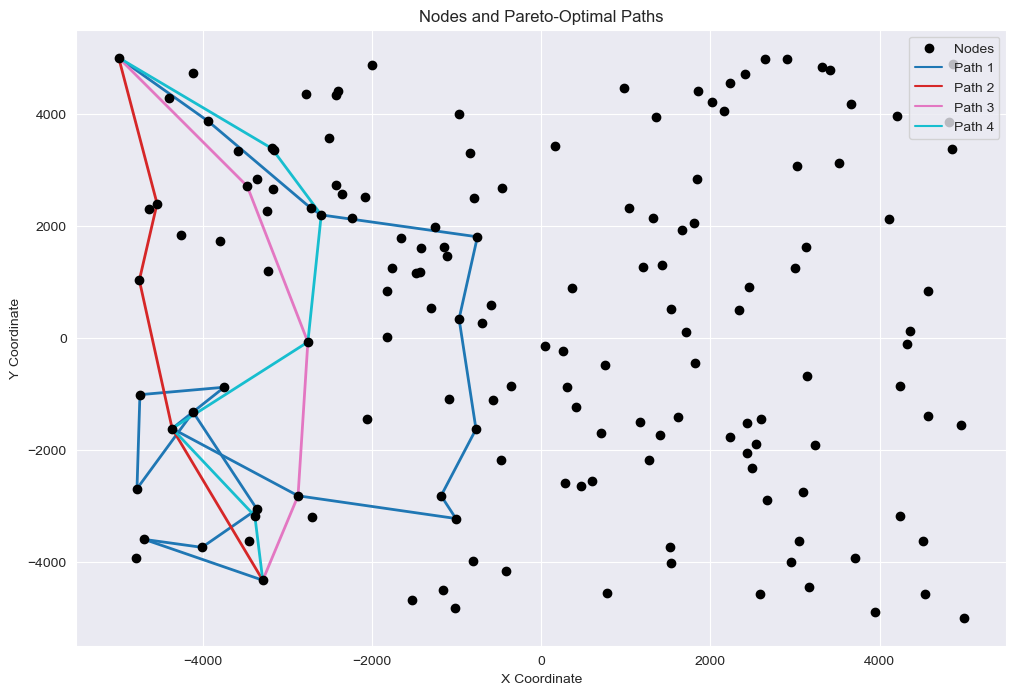

In [276]:
plot_points(position_data, pareto_optimal_paths)

# The Final Solution for all paths.

In [278]:
import json

all_results = []

for i in range(1, 150):
    # Run PSO
    final_population, final_best_fitness = pso(graph=G, start_node=i, df=distance_df, max_length=20, iterations=100)

    # Compute rates and latencies
    results = rate_latency(final_population)
    pareto_optimal_paths = find_pareto_optimal_paths(final_population, results)

    # Prepare the result for the current node
    result = {
        "Source Node": f"Node-{i}",
        "Routing-paths": [path for path, _ in pareto_optimal_paths],
        "End-to-end data rate and latency": [
            {"Transmission Rate": rate, "Latency": latency} for _, (rate, latency) in pareto_optimal_paths
        ],
    }

    # Append the result to the list
    all_results.append(result)

# Save all results to a JSON file
with open('result.json', 'w') as f:
    json.dump(all_results, f, indent=4)


Iteration 0: Global Best Fitness = -0.21286660359508042
Global Best Position: [1, 8.0, 150.0, 133.0, 36.0, 134.0, 136.0, 115.0, 41.0, 84.0, 145.0, 151.0]
Iteration 10: Global Best Fitness = -0.35572374645222327
Global Best Position: [1, 8.0, 150.0, 133.0, 36.0, 134.0, 136.0, 115.0, 41.0, 118.0, 72.0, 151.0]
Iteration 20: Global Best Fitness = -0.35572374645222327
Global Best Position: [1, 8.0, 150.0, 133.0, 36.0, 134.0, 136.0, 115.0, 41.0, 118.0, 72.0, 151.0]
Iteration 30: Global Best Fitness = -0.35572374645222327
Global Best Position: [1, 8.0, 150.0, 133.0, 36.0, 134.0, 136.0, 115.0, 41.0, 118.0, 72.0, 151.0]
Iteration 40: Global Best Fitness = -0.35572374645222327
Global Best Position: [1, 8.0, 150.0, 133.0, 36.0, 134.0, 136.0, 115.0, 41.0, 118.0, 72.0, 151.0]
Iteration 50: Global Best Fitness = -0.35572374645222327
Global Best Position: [1, 8.0, 150.0, 133.0, 36.0, 134.0, 136.0, 115.0, 41.0, 118.0, 72.0, 151.0]
Iteration 60: Global Best Fitness = -0.35572374645222327
Global Best Po